In [1]:
import json
from pprint import pprint
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
from src.reinforcement.goal_directed_model_based_rl.model import SimpleStochasticActorCritic,\
    SimpleStochasticModelDynamics, SimpleDeterministicPolicy, SimpleDeterministicModelDynamics, EnsembleDeterministicModelDynamicsDeltaPredict
from src.reinforcement.goal_directed_model_based_rl.env import VTLEnvWithReferenceTransitionMaskedEntropyScore
from src.reinforcement.goal_directed_model_based_rl.algs.model_based_multi_step_backprop_with_ensemble_classifier import ModelBasedMultiStepBackPropWithEnsembleClassifier
from src.speech_classification.pytorch_conv_lstm import LstmNet, LstmNetEnsemble


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [22]:
model_dir = r'C:\Study\SpeechAcquisitionModel\reports\videos\\video_ensemble_multi_step_05_18_2019_07_01_PM'

In [23]:
with open(model_dir+ '/config.json') as data_file:
    kwargs = json.load(data_file)

In [24]:
device = 'cpu'
kwargs['mbbackprop']['device'] = device

speaker_fname = os.path.join(kwargs['env']['vtl_dir'], 'JD2.speaker')

lib_path = os.path.join(kwargs['env']['vtl_dir'], 'VocalTractLab2.dll')

env = VTLEnvWithReferenceTransitionMaskedEntropyScore(lib_path, speaker_fname, **kwargs['env'])
env.reset(train_mode=True)

Compile date of the library: "Mar  6 2019"


array([ 2.66517292e-01, -4.23394096e+00,  0.00000000e+00, -4.39989107e+00,
        8.91013641e-02,  1.07782053e+00,  9.99429576e-01,  4.66974654e-02,
        1.55039778e-02, -1.15259205e-01, -1.87878533e+00,  4.20619675e+00,
       -1.58131052e+00,  3.14065347e+00, -6.67073289e-01, -2.77509133e+00,
       -3.11807543e+00,  1.37406547e+00, -1.67344428e-01,  6.30115722e-01,
        9.01040221e-02, -5.00000000e-02, -4.34483654e-02, -3.91177799e-02,
        7.27673627e-05,  1.32998242e-04,  1.14259245e-04,  1.39652037e-04,
        1.23002631e-04,  4.64159353e-03,  4.58444024e-03,  1.16650433e-03,
        4.19654920e-03,  3.92569361e-03,  9.31010886e-05,  2.35009032e-05,
        2.78307480e-05,  2.22916645e-04,  1.73795420e-03,  5.59961831e-04,
        3.12687452e-04,  9.17890151e-05,  3.16391887e-05,  1.20681259e-05,
        1.28688539e-05,  1.53881197e-05,  1.66057556e-05,  1.81838709e-05,
        2.00268899e-05,  2.23497709e-05, -1.10512677e-02, -4.40118100e+00,
        7.49568888e-02,  

In [25]:
model_dynamics = torch.load(model_dir + '/model_dynamics.pickle')
agent = torch.load(model_dir + '/agent.pickle')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


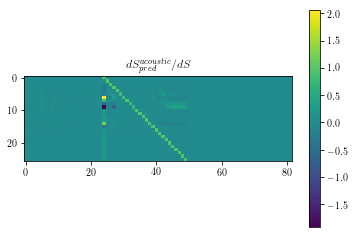

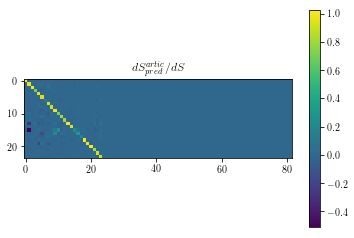

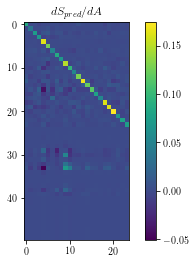

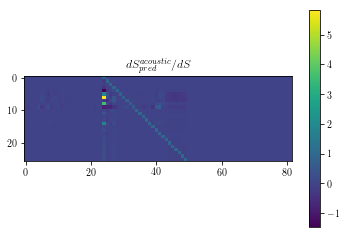

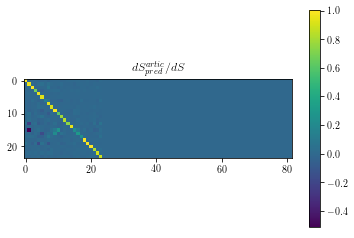

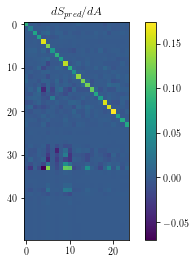

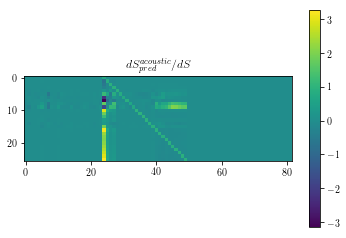

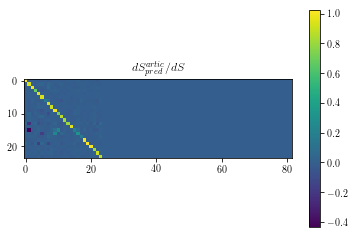

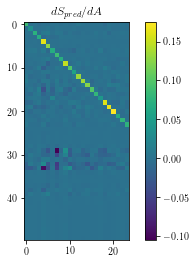

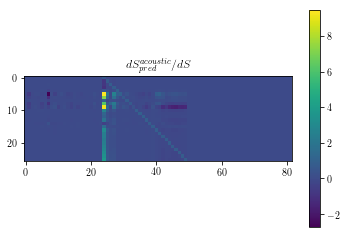

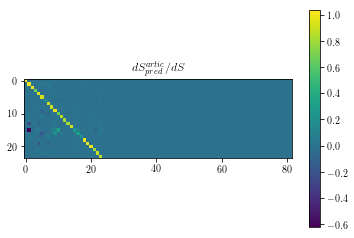

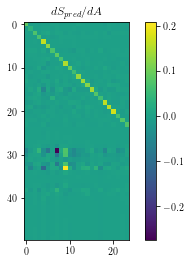

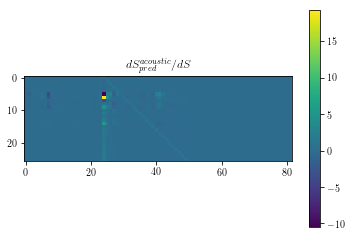

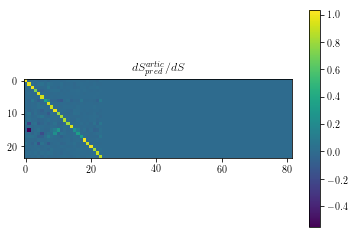

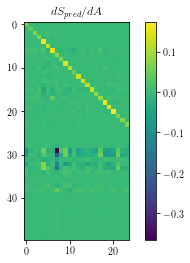

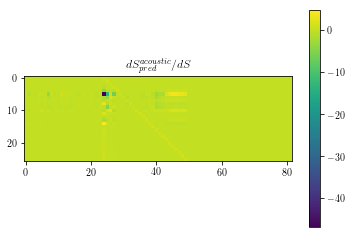

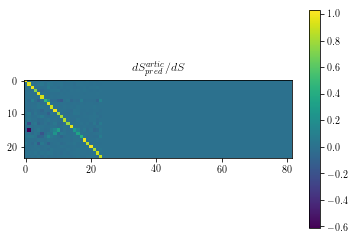

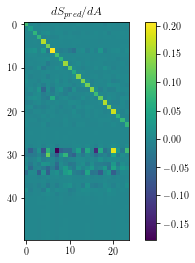

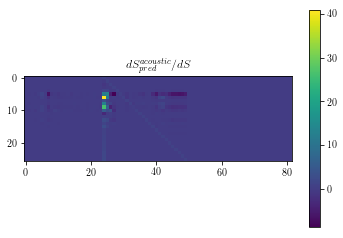

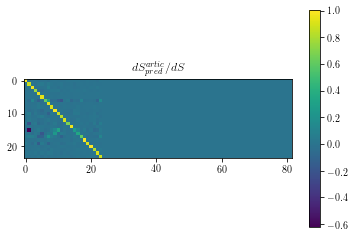

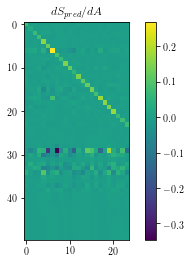

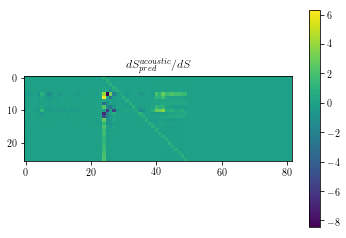

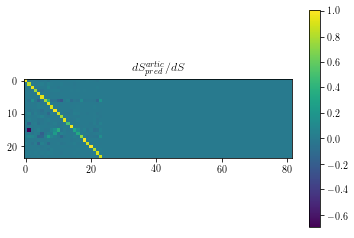

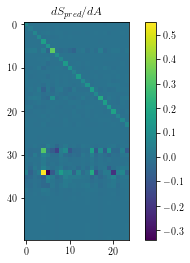

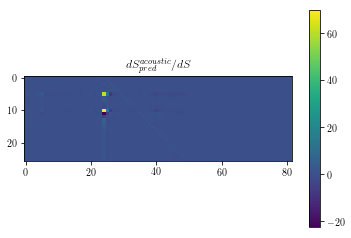

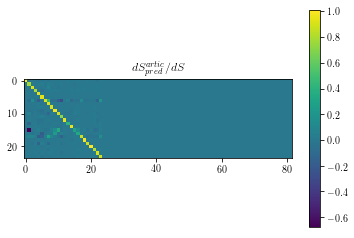

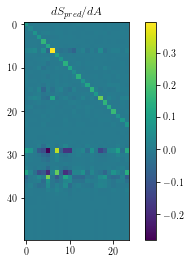

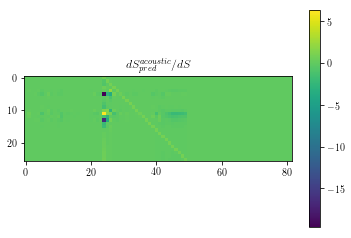

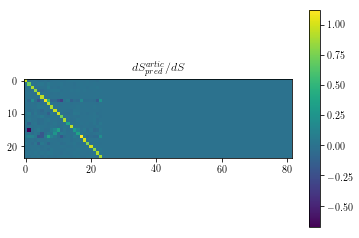

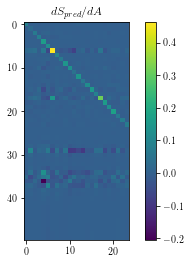

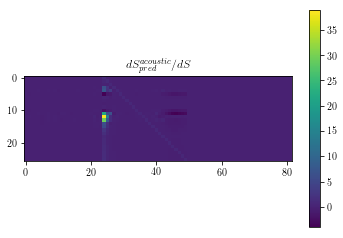

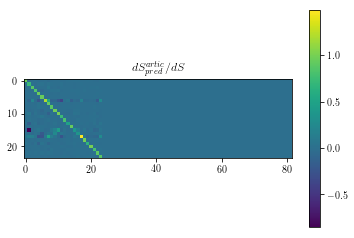

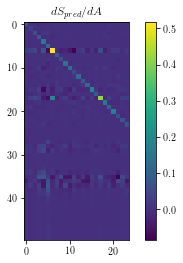

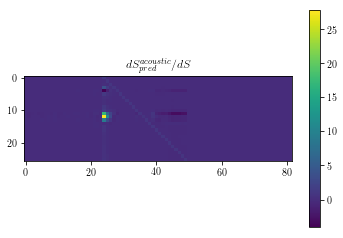

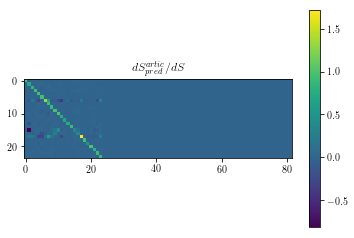

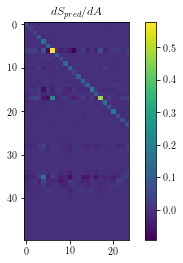

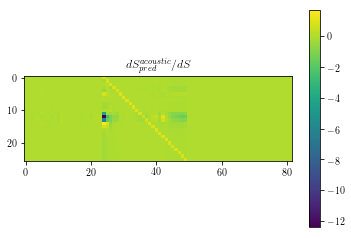

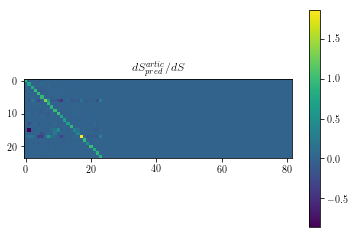

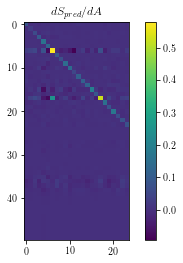

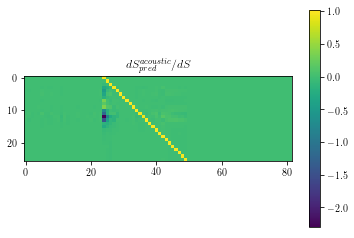

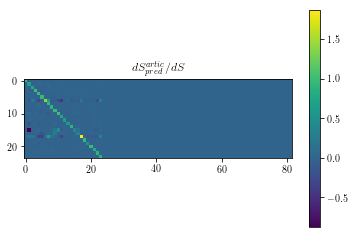

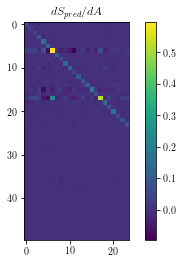

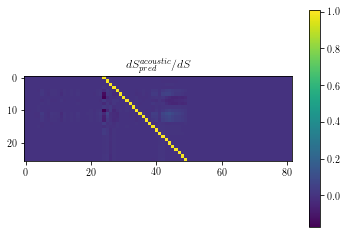

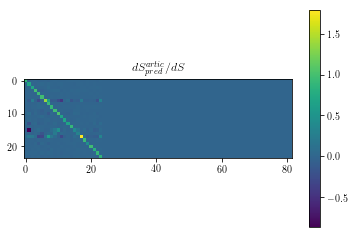

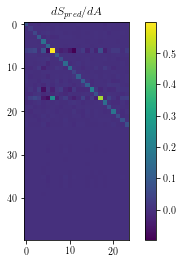

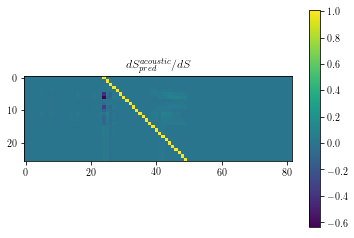

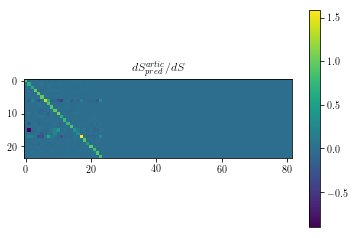

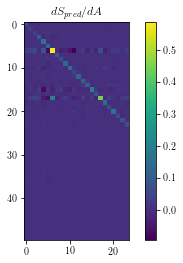

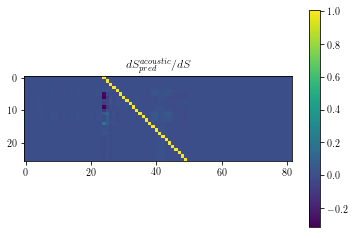

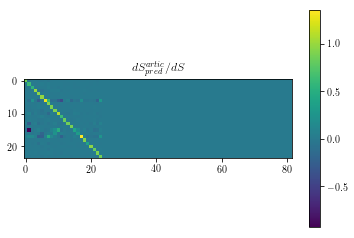

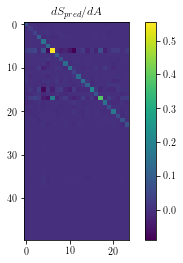

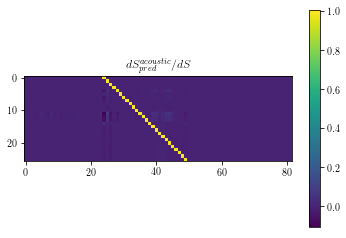

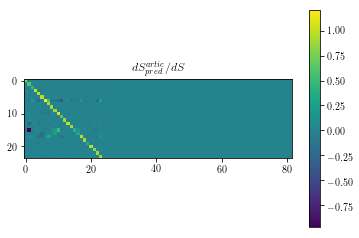

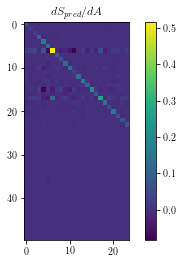

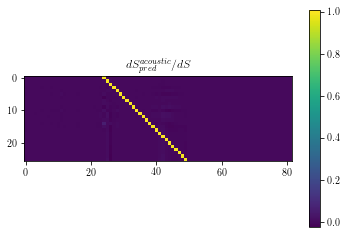

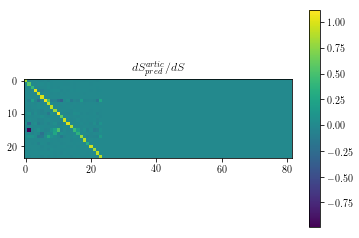

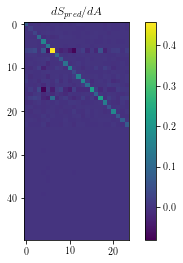

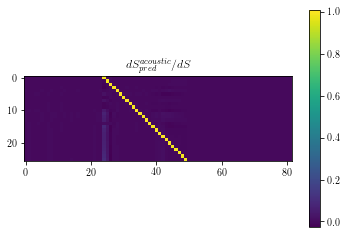

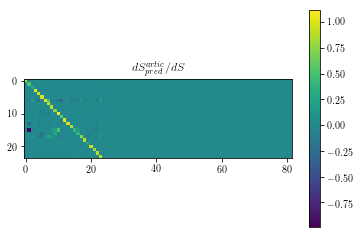

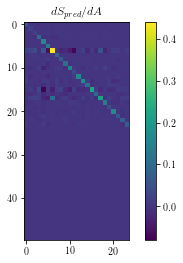

In [28]:
ep_states = []
ep_states_pred = []
ep_states_std_pred = []
ep_actions = []
misses = []

T = len(env.get_current_reference())
state0 = env.reset()
state = state0
env.render()
state = env.normalize(state, env.state_bound)
ep_states.append(state)
ep_states_pred.append(state[:-env.goal_dim])


# axes[0].cla()

score = 0.

agent.eval()
model_dynamics.eval()
step = 0
terminated = False

probs = []
entropies = []

while True:
    state_tensor = torch.tensor(torch.from_numpy(state).float().to(device).view(1, -1), requires_grad=True)
    action = agent(state_tensor).detach().cpu().numpy().squeeze()
    ep_actions.append(action)
    action_denorm = env.denormalize(action, env.action_bound)
    next_state, reward, done, _ = env.step(action_denorm)

    probs.append(reward[0].detach().cpu().numpy())
    entropies.append(reward[1].detach().cpu().numpy())

    action_tensor = torch.tensor(torch.from_numpy(action).float().to(device).view(1,-1), requires_grad=True)
    
    next_state_pred, next_state_pred_std, _ = model_dynamics(state_tensor, action_tensor)
    
    
    saliency_state = []    
    saliency_action = []

    for d in range(next_state_pred.shape[-1]):
#         state_tensor.grad.data.zero_()
#         next_state_pred[:, d].backward(retain_graph=True)
        grad = torch.autograd.grad(next_state_pred[:, d], state_tensor, retain_graph=True)
#         grad = state_tensor.grad.data.detach().numpy()
        saliency_state.append(grad[0].numpy())
    
        grad1 = torch.autograd.grad(next_state_pred[:, d], action_tensor, retain_graph=True)
        saliency_action.append(grad1[0].numpy())
    
    
#         state_tensor.grad.data.zero_()
    saliency_state = np.array(saliency_state).squeeze()
    plt.imshow(saliency_state[-26:, :])
    plt.colorbar()
    plt.title(r'$d S_{pred}^{acoustic} /  dS $')
    plt.show()
    
    saliency_state = np.array(saliency_state).squeeze()
    plt.imshow(saliency_state[:-26, :])
    plt.colorbar()
    plt.title(r'$d S_{pred}^{artic} /  dS $')
    plt.show()
    
    saliency_action = np.array(saliency_action).squeeze()
    plt.imshow(saliency_action)
    plt.colorbar()
    plt.title(r'$d S_{pred} /  dA $')
    plt.show()
    
    next_state = env.normalize(next_state, env.state_bound)
    
    ep_states.append(next_state)
    ep_states_pred.append(next_state_pred.detach().cpu().numpy().squeeze())
    ep_states_std_pred.append(next_state_pred_std.detach().cpu().numpy().squeeze())
    
    next_state_pred = env.denormalize(next_state_pred.detach().cpu().numpy().squeeze(), env.state_bound[:-env.goal_dim])

    
    
    
    env.render()
    
    miss = torch.abs(torch.from_numpy(next_state).float().to(device)[:-env.goal_dim][torch.from_numpy(np.array(env.state_goal_mask, dtype=np.uint8)).byte()] -
                     torch.from_numpy(state).float().to(device)[-env.goal_dim:])

    misses.append(miss[:].max().detach().cpu().numpy())

    if len(misses) > 3 and np.all(np.array(misses[-3:]) > 0.1) and not terminated:
        terminated = True
        res_step = step
        miss_max_idx = np.argmax(miss[:].detach().cpu().numpy())
    elif not terminated:
        score = step
   
    if np.any(done):

        break
    state = next_state
    step += 1

(21, 82)
(21, 50)


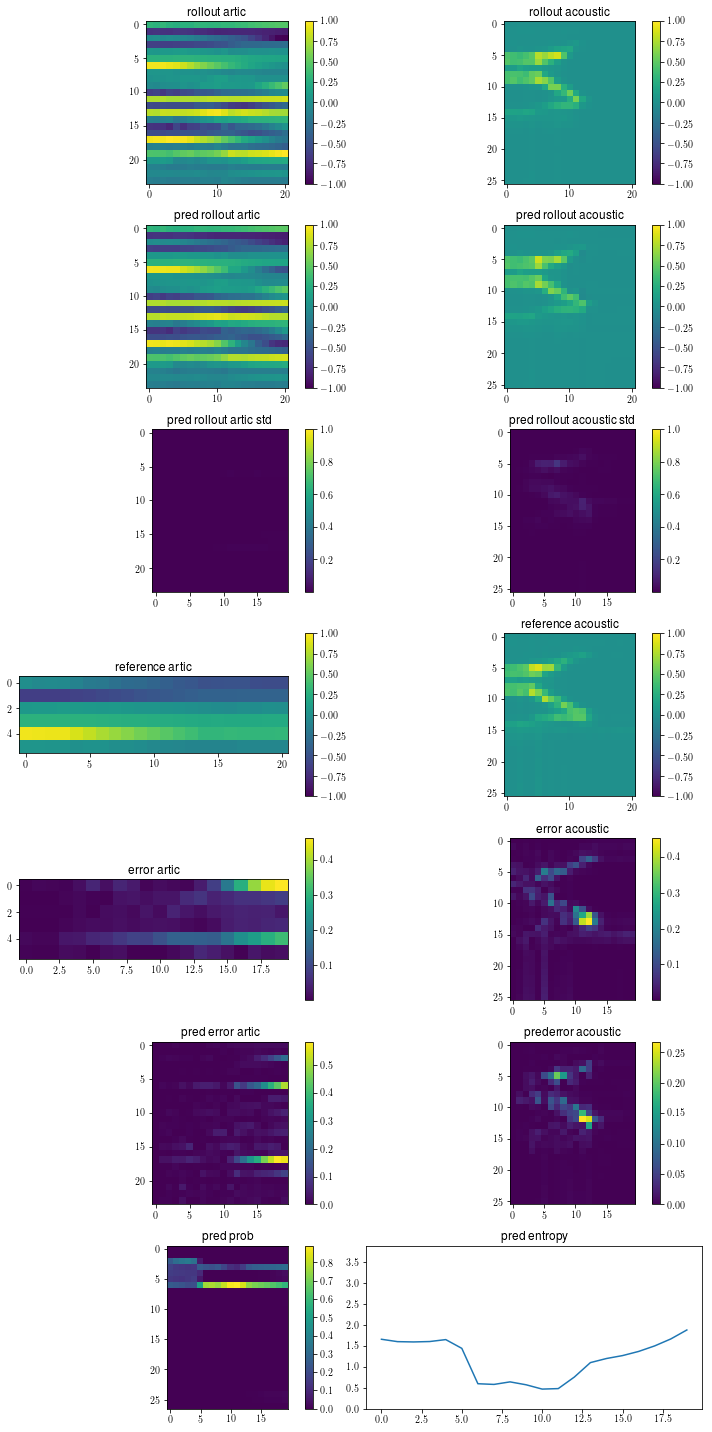

In [29]:
n_audio = 26
n_artic = 24
n_artic_goal = 6


# Share a X axis with each column of subplots
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
cb = None
# plt.ion()
# plt.show()



# ep_states = env.normalize(np.array(ep_states), env.state_bound)
ep_states = np.array(ep_states)
im0 = axes[0, 0].imshow(np.array(ep_states)[:, :n_artic].T, vmin=-1., vmax=1.)
axes[0, 0].set_title('rollout artic')
plt.colorbar(im0, ax=axes[0, 0])

im0 = axes[0, 1].imshow(np.array(ep_states)[:, n_artic: n_artic+n_audio].T, vmin=-1., vmax=1.)
axes[0, 1].set_title('rollout acoustic')
plt.colorbar(im0, ax=axes[0, 1])
# im_pred = axes[1].imshow(np.array(ep_states_pred)[:, -n_audio:].T, vmin=vmin, vmax=vmax)

im_pred = axes[1, 0].imshow(np.array(ep_states_pred)[:, :n_artic].T, vmin=-1., vmax=1.)
axes[1, 0].set_title('pred rollout artic')
plt.colorbar(im_pred, ax=axes[1, 0])

im_pred = axes[1, 1].imshow(np.array(ep_states_pred)[:, n_artic: n_artic+n_audio].T, vmin=-1., vmax=1.)
axes[1, 1].set_title('pred rollout acoustic')
plt.colorbar(im_pred, ax=axes[1, 1])

im_pred = axes[2, 0].imshow(np.array(ep_states_std_pred)[:, :n_artic].T, vmax=1.)
axes[2, 0].set_title('pred rollout artic std')
plt.colorbar(im_pred, ax=axes[2, 0])

im_pred = axes[2, 1].imshow(np.array(ep_states_std_pred)[:, n_artic: n_artic+n_audio].T, vmax=1.)
axes[2, 1].set_title('pred rollout acoustic std')
plt.colorbar(im_pred, ax=axes[2, 1])

if n_artic_goal > 0:
    im1 = axes[3, 0].imshow(ep_states[:, -env.goal_dim: -env.goal_dim + n_artic_goal].T, vmin=-1., vmax=1.)
    axes[3, 0].set_title('reference artic')
    plt.colorbar(im1, ax=axes[3, 0])

im1 = axes[3, 1].imshow(ep_states[:, -env.goal_dim + n_artic_goal:].T, vmin=-1., vmax=1.)
axes[3, 1].set_title('reference acoustic')
plt.colorbar(im1, ax=axes[3, 1])

diff_img = np.abs(np.array([ep_states[i, -env.goal_dim:] - np.array(ep_states)[i + 1, :-env.goal_dim][env.state_goal_mask] for i in range(len(ep_states)-1)]))
# diff_img_normed = env.normalize(diff_img.T, env.state_bound[:-env.goal_dim])
diff_img_normed = diff_img

if n_artic_goal > 0:
    im2 = axes[4, 0].imshow(np.array(diff_img_normed[:, :n_artic_goal].T))
    axes[4, 0].set_title('error artic')
    plt.colorbar(im2, ax=axes[4, 0])

im2 = axes[4, 1].imshow(np.array(diff_img_normed[:, -n_audio:].T))
axes[4, 1].set_title('error acoustic')
plt.colorbar(im2, ax=axes[4, 1])

print(ep_states.shape)
print(np.array(ep_states_pred).shape)

pred_err_img = np.abs(np.array(
    [ep_states[i, :-env.goal_dim] - np.array(ep_states_pred)[i, :] for i in
     range(len(ep_states) - 1)]))
# diff_img_normed = env.normalize(diff_img.T, env.state_bound[:-env.goal_dim])
im3 = axes[5, 0].imshow(np.array(pred_err_img[:, :n_artic].T))
axes[5, 0].set_title('pred error artic')
plt.colorbar(im3, ax=axes[5, 0])

im3 = axes[5, 1].imshow(np.array(pred_err_img[:, n_artic:n_artic + n_audio].T))
axes[5, 1].set_title('prederror acoustic')
plt.colorbar(im3, ax=axes[5, 1])

im4 = axes[6, 0].imshow(np.array(probs).T, vmin=0., vmax=np.array(probs).T.max())
# axes[5, 1].ylim((0, 1.0))
axes[6, 0].set_title('pred prob')
plt.colorbar(im4, ax=axes[6, 0])

im4 = axes[6, 1].plot(np.array(entropies))
axes[6, 1].set_ylim(bottom=0, top=np.array(entropies).max()+2)
axes[6, 1].set_title('pred entropy')
# plt.colorbar(im4, ax=axes[4, 1])

# if cb is None:
# cb = plt.colorbar(im0, ax=axes[0, 1])
# plt.colorbar(im_pred, ax=axes[1, 1])
# plt.colorbar(im1, ax=axes[2, 1])
# plt.colorbar(im2, ax=axes[3, 1])
# plt.colorbar(im3, ax=axes[4, 1])
plt.tight_layout()
# plt.draw()
# plt.pause(.001)
plt.show()

In [12]:
np.array(ep_states)[:, n_artic: n_artic+n_audio]

array([[7.27752752e-01, 1.33021379e+00, 1.14273645e+00, 1.39666870e+00,
        1.23047096e+00, 4.64228828e+01, 4.58642906e+01, 1.16617942e+01,
        4.19558100e+01, 3.92422217e+01, 9.31062999e-01, 2.34960048e-01,
        2.78763216e-01, 2.22900617e+00, 1.73837858e+01, 5.60625061e+00,
        3.13062523e+00, 9.18146070e-01, 3.16087356e-01, 1.21073102e-01,
        1.29031865e-01, 1.54884722e-01, 1.67640039e-01, 1.82580866e-01,
        1.99887580e-01, 2.23414198e-01],
       [7.30887728e-01, 1.44571013e+00, 1.33672096e+00, 1.39906504e+00,
        6.71997001e-01, 3.51928963e+01, 3.96663262e+01, 1.05569886e+01,
        4.22502316e+01, 4.69635453e+01, 1.88350420e+00, 5.07607266e-01,
        3.49930937e-01, 1.68666057e+00, 1.95128262e+01, 4.61813915e+00,
        2.91602119e+00, 6.02523811e-01, 2.88714762e-01, 1.35529010e-01,
        1.45436888e-01, 1.54379500e-01, 1.70433733e-01, 1.78549532e-01,
        1.93043523e-01, 2.13418658e-01],
       [7.71991629e-01, 1.53770376e+00, 1.17495705e+00

In [13]:
env.state_bound


array([[ 0.  ,  1.  ],
       [-6.  , -3.5 ],
       [-0.5 ,  0.  ],
       [-7.  ,  0.  ],
       [-1.  ,  1.  ],
       [-2.  ,  4.  ],
       [ 0.  ,  1.  ],
       [-0.1 ,  1.  ],
       [ 0.  ,  1.  ],
       [-3.  ,  4.  ],
       [-3.  ,  1.  ],
       [ 1.5 ,  5.5 ],
       [-3.  ,  2.5 ],
       [-3.  ,  4.  ],
       [-3.  ,  5.  ],
       [-4.  ,  2.  ],
       [-6.  ,  0.  ],
       [-1.4 ,  1.4 ],
       [-1.4 ,  1.4 ],
       [-1.4 ,  1.4 ],
       [-1.4 ,  1.4 ],
       [-0.05,  0.3 ],
       [-0.05,  0.3 ],
       [-0.05,  0.3 ],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.01,  0.01],
       [-0.

In [14]:
np.array(ep_states)[:, -n_audio:]

array([[8.63325747e-01, 2.29670255e+00, 1.07454573e+00, 1.24463039e+00,
        2.51624001e+00, 3.39598755e+01, 3.85525721e+01, 1.27892927e+01,
        4.32096617e+01, 4.39046854e+01, 1.39041706e+00, 4.86256781e-01,
        4.33628633e-01, 2.26072880e+00, 1.68983302e+01, 6.08008581e+00,
        3.17087508e+00, 8.46899625e-01, 2.57772609e-01, 1.22047733e-01,
        1.59736019e-01, 2.00101820e-01, 2.29877525e-01, 2.56696817e-01,
        2.87280694e-01, 3.23394300e-01],
       [1.00048206e+00, 2.29468148e+00, 1.41593411e+00, 1.42537558e+00,
        1.50821187e+00, 3.46326404e+01, 4.13674853e+01, 1.26307551e+01,
        4.22315275e+01, 4.17646197e+01, 1.18299842e+00, 4.13247685e-01,
        6.80795946e-01, 1.77817736e+00, 2.14880370e+01, 5.84642030e+00,
        3.23740274e+00, 8.87622343e-01, 6.17251877e-01, 5.71875401e-01,
        6.32069721e-01, 7.04481272e-01, 8.12978770e-01, 9.17199541e-01,
        1.01670139e+00, 1.13760530e+00],
       [7.38205041e-01, 1.53994842e+00, 1.04910044e+00